# Exploring Ectomycorrhizal Diversity across NEON sites with Remote Sensing

Remote sensing gives us a picture of what's happening on the Earth's surface and while EcM fungi live in the soil, their presence may have an affect on dynamics aboveground. Relating variations in vegetation characteristics to EcM diversity may help us better understand this relationship. 

## Importing Libraries and Configuring Notebook
We import a few packages which will help us process and visualize the data. Notably, we import the ee library. This is a python library which allows for API queries to the Google Earth Engine platform. The API requests require authentication. When you run the `ee.Initialize` you'll be asked to log into an Earth Engine account and select a project on which to run the queries. You can create a new project if you need. `ee.Initialize` saves your account credentials to your Python environment and `ee.Authenticate` validates those credentials. 

Google Earth Engine is a great tool for processing large amounts of imagery data. Given that the fungal diversity data was collected over a large spatial and temporal range this processing power is very useful. Luckily, Google Earth Engine hosts Sentinel 2 imagery from which a comprehensive array of vegetation indices can be calculated.

In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats

import ee

import warnings
warnings.filterwarnings("ignore")

In [2]:
ee.Initialize()
ee.Authenticate()

True

## Aggregating EcM Fungi Surveys
The data shows that a soil sample survey consists of collecting multiple samples from a 40 sq. meter plot. Given that we will be working with Sentinel 2 data which has a maximum spatial resolution of 10 meters, we take the average Shannon Diversity across samples for each plot survey. The Shannon Diversity Index is preferred because it characterizes the richness and evenness of a sample.

We also need to create date windows around each survey to find temporal overlap with the Sentinel 2 images. Sentinel 2 has a revisit frequency of 10 days. The plots within each site, typically get sampled within days of one another. By finding the start and end dates of these field campaigns we can reduce the number of images that we request from Google Earth Engine. Taking the mean across multiple images collected around the same time can also help to account for atmospheric effects and artefacts in the multispectral imagery. 

In [3]:
#Read in the climate_sdi dataframe produced in EcMDiversityandClimate.ipynb
clim_sdi = pd.read_csv("../data/climate_sdi.csv")
clim_sdi['collectDate'] = pd.to_datetime(clim_sdi['collectDate']) #re-set type to datetime

In [4]:
#For each plot and date, take the mean Shannon Diversity
survey_sdi = clim_sdi.groupby(['site','plotID', 'collectDate', 'latitude', 'longitude'])['shannon_diversity'].agg("mean").reset_index()

#Save a copy of the index for lookup
survey_sdi['survey_id'] = survey_sdi.index

In [5]:
#Find groups of similar dates for each site as 'windows'
survey_sdi = survey_sdi.sort_values("collectDate")

windows = [] 
window_max_size = 30

#Iterate over each site, identifying and keeping track of survey date windows
for site, group in survey_sdi.groupby("site"):
    sorted_dates=group['collectDate'].values
    survey_indices = group.index.values
    
    #Initialize window for site dates
    c_window_minmax = [sorted_dates[0], sorted_dates[0]]
    order = 0
    
    for survey_index in survey_indices:
        c_date = group['collectDate'].loc[survey_index]
        
        if ((c_date - c_window_minmax[0]) / np.timedelta64(1, "D")) <= window_max_size:
            c_window_minmax[1] = c_date

            
        else:
            windows.append([f"{site}_{order}", site, c_window_minmax[0], c_window_minmax[1]])
            c_window_minmax = [c_date, c_date]
            order += 1
                
        #Keep track of which window each unique plot, date pair belongs to
        survey_sdi.loc[survey_index, "window_id"] = f"{site}_{order}"
            
    windows.append([f"{site}_{order}", site, c_window_minmax[0], c_window_minmax[1]])
    
#Create a related table with properties describing each window
window_df = pd.DataFrame(windows, columns=['window_id', 'site', 'start_date', 'end_date'])

#Expand each window to include at least a 20 day interval for collecting images
window_df['start_date'] = window_df['start_date'] - np.timedelta64(10,'D')
window_df['end_date'] = window_df['end_date'] + np.timedelta64(10,'D')

print(f"{len(survey_sdi)} surveys consolidated into {len(window_df)} imagery windows")

#Keep track of order of windows per site
survey_sdi['window_rank'] = survey_sdi['window_id'].apply(lambda x: x.split("_")[1])

2426 surveys consolidated into 263 imagery windows


**Observation Windows**

In the following plot, the surveys conducted at each site are grouped by observation window and visualized. It is a quick way to validate that surveys have been appropriately clustered into their field campaigns.

<Figure size 2000x1000 with 0 Axes>

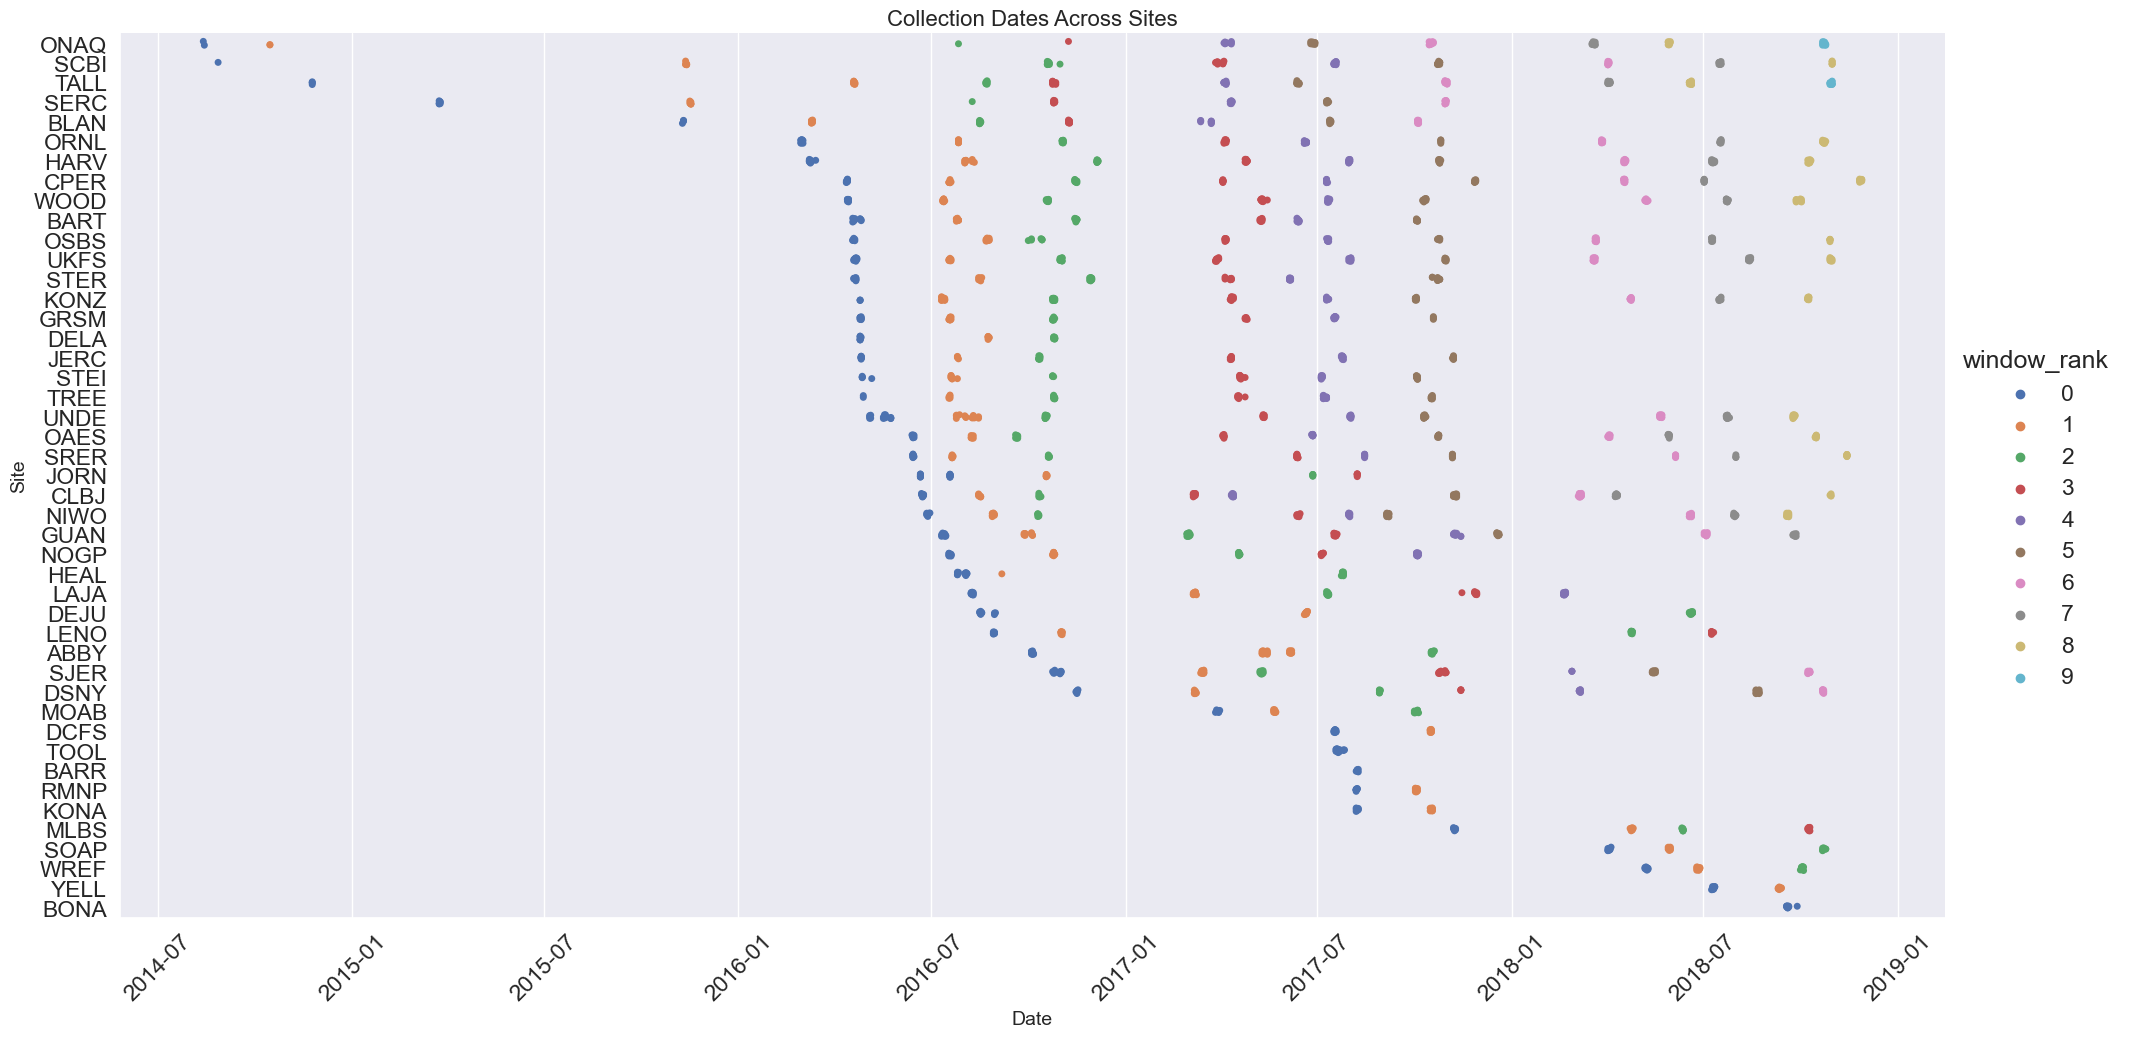

In [6]:
plt.figure(figsize=(20,10));
sns.set(font_scale=1.5);
sns.catplot(data=survey_sdi, x='collectDate', y='site', hue="window_rank", height=10, aspect=2);

# # Enhance the plot with titles and labels
plt.title('Collection Dates Across Sites', fontsize=16)
plt.xlabel('Date', fontsize=14);
plt.ylabel('Site', fontsize=14);

# Rotate date labels for better readability
plt.xticks(rotation=45);


In [7]:
#Each window will also need the lat/lon bounds of the site it captures

#Find Lat Lon boundaries of each site by creating four points from the maximum and minimum lat lon
site_geobounds = survey_sdi.groupby("site").agg({"latitude":["min", "max"], "longitude":["min", "max"]})

def CreateGEEPolygonBounds(geobounds):
    coords = [
        [geobounds['longitude']['min'], geobounds['latitude']['min']],
        [geobounds['longitude']['min'], geobounds['latitude']['max']],
        [geobounds['longitude']['max'], geobounds['latitude']['max']],
        [geobounds['longitude']['max'], geobounds['latitude']['min']],
        [geobounds['longitude']['min'], geobounds['latitude']['min']]]
    return ee.Geometry.Polygon([coords])
    
#dict of {site(str):geobounds(ee.Geometry.Polygon)}    
site_polygon_dict = site_geobounds.apply(CreateGEEPolygonBounds, axis=1).to_dict()

#relate each window to its site geoboundaries
window_df['ee_Polygon_geobound_ptr'] = window_df.apply(lambda w: site_polygon_dict[w['site']], axis=1)

## Aggregating RECl for each Window and Extracting at Plot Level

Ectomycorrhizal Fungi from a crucial relationship in the natural world, cycling organic compounds such as Nitrogen and Phosphorous to plants. While researchers are working hard to develop methods for observing the transfer of nutrients and the nutrient fluxes taking place in and along hyphal connections we may be able to use remotely sensed observations of the Earth's surface to gain some insight. According to several studies investigating the relationship between chlorophyll content in crops and available organic nitrogen in the soil there is a strong correlation between plant nitrogen accumulation and canopy chlorophyll content (Liu et al., 2017; Peng et al., 2017). I'm curious whether the important role that EcM play in the nitrogen cycle can be better understood by investigating changes in EcM diversity with respect to canopy Chlorophyll content. Canopy Chlorophyll content can be measured by a calculated band index; The Red-Edge Chlorophyll Index (RECl) (Gitelson et al., 2003;2006). 

We have defined a set of observation windows by date and area to reduce the number of images that will be processed by Google Earth Engine, to calculate an aggregated index, and to reduce the influence of imagery artifacts and clouds. For each of these observation windows, a collection of Sentinel 2 images is gathered, RECl is calculated on them, and the mean RECl for each pixel is taken to create a meanRECl image. Mean RECl samples are taken from the image at each plot and combined into the `survey_sdi` dataframe.

In [8]:
#Create a point(ee.Feature) representing each survey
survey_features = survey_sdi.apply(lambda s: ee.Feature(ee.Geometry.Point(s['longitude'], s['latitude']), s.to_dict()), axis=1)
survey_feature_collection = ee.FeatureCollection(list(survey_features.values))
survey_sdi['ee_Feature_ptr'] = survey_features

In [9]:
#Define the vegetation index (Red Edge Chlorophyll Index)
def addRECl(image):
    recl = image.expression(
        '(B7 / B5) - 1', {
            'B7': image.select('B7'),
            'B5': image.select('B5')
        }).rename('RECl')
    return image.addBands(recl)

**The cell below takes some time to run,** it uses the Google Earth Engine API to filter through a large number of images to collect images described by the observation windows.

In [10]:
def ProcessWindow(start_date, end_date, geobounds, survey_features):
    """Given an observation window, fetch images from that window and return calculated mean RECl sampled at survey_features

    Arguments:
    start_date -- start date for imagery collection
    end_date -- end date for imagery collection
    geobounds -- (ee.Geometry.Polygon) for filterBounds
    survey_features -- (ee.FeatureCollection) for reduceRegions collection
    
    Returns:
    results -- (dictionary) describing ee.FeatureCollection where features are survey_features with 'mean' property set to meanRECl
    """
    start_date = ee.Date(start_date.strftime('%Y-%m-%d'))
    end_date = ee.Date(end_date.strftime('%Y-%m-%d'))
    
    #Consider cloud filtering
    s2 = ee.ImageCollection('COPERNICUS/S2').filterDate(start_date, end_date).filterBounds(geobounds).map(addRECl).select('RECl')
    
    s2_size = s2.size();
    meanRECl = ee.Algorithms.If(
        ee.Number(s2.size()).gt(0),
        s2.mean().reduceRegions(collection = survey_features, reducer = ee.Reducer.mean(), scale = 20, crs="EPSG:4326"),
        survey_features.set('mean', None)
    )
    return meanRECl.getInfo()

#Iterate over windows and find meanRECl samples for plots within each
for _index, window in window_df.iterrows():
    site = window['site']
    geobounds = window['ee_Polygon_geobound_ptr']
    survey_features = ee.FeatureCollection(list(survey_sdi.loc[survey_sdi['window_id'] == window["window_id"]]["ee_Feature_ptr"].values))
    
    results = ProcessWindow(window['start_date'], window['end_date'], geobounds, survey_features)
    
    for result_feature in results['features']: 
        survey_sdi.loc[survey_sdi['survey_id'] == result_feature['properties']['survey_id'], "meanRECl"] = result_feature['properties'].get("mean", None)

## Quantifying the Relationship between EcM Diversity and Canopy Chlorophyll Content
Before comparing EcM diversity to RECl, the two variables are tested for normality. Shapiro-Wilks yields that these two variables are not likely normally distributed and so the non-parametric Spearman correlation tests will be used. 

Calculating the Spearman Rank correlation between meanRECl and Shannon Diversity reveals that there is a statistically effect of meanRECl on fungal diversity. The LOWESS curve helps to visualize the relationship throughout the RECl distribution. However, this correlation is only weakly positive. Though the correlation is weak, we have enough samples to generate a p-value that allows us to reject the null hypothesis under any reasonable threshold. The null hypothesis being that these two variables are explained by uncorrelated distributions.

In [11]:
print(f"The Red-Edge Chlorophyll Index is not likely approximated by the normal distribution: {scipy.stats.shapiro(survey_sdi['meanRECl'])}")
print(f"Shannon Diversity is also not likely approximated by the normal distribution: {scipy.stats.shapiro(survey_sdi['shannon_diversity'])}")

The Red-Edge Chlorophyll Index is not likely approximated by the normal distribution: ShapiroResult(statistic=nan, pvalue=1.0)
Shannon Diversity is also not likely approximated by the normal distribution: ShapiroResult(statistic=0.9977641105651855, pvalue=0.0016023507341742516)


In [12]:
#Calculate the Spearman Rank Correlation Coefficient
RECl_sdi_spearman = scipy.stats.spearmanr(survey_sdi['shannon_diversity'], survey_sdi['meanRECl'], nan_policy="omit")
print(f"Spearman Rank Correlation Test r:{RECl_sdi_spearman[0]} p-value:{RECl_sdi_spearman[1]}")

Spearman Rank Correlation Test r:0.18964019447234184 p-value:7.069800451334933e-21


In [13]:
#Commenting out code for generating visualization. Chart finished in Illustrator.
"""
plt.figure(figsize= (20,10));

jointplot = sns.jointplot(data=survey_sdi, x="meanRECl", y="shannon_diversity", kind="reg", height=10, ratio=5, line_kws= {'color':'red'}, joint_kws={"scatter_kws": {"alpha": 0.5}, "lowess": True});
ax = plt.gca();

print(f"Spearman r: {round(RECl_sdi_spearman[0], 4)}", f"n: {len(survey_sdi)}")

sns.set(font_scale=2.0)
plt.xlabel("Red-Edge Chlorophyll Index");
plt.xlim(0, 6);
plt.ylabel("Shannon Diversity");
""";

## Final Visualization
<p align="center">
<img src="../figures/RECl_EcM_Diversity.png" alt="Alternative text" width=800/>
</p>
<!-- ![RECl_EcM_Diversity](../figures/RECl_EcM_Diversity.png "RECl Ectomycorrhizal Diversity" ) -->

## Next Steps
The correlation between chlorophyll content and EcM diversity was found to be not very strong. Given the skewness of the Red-Edge Chlorophyll index, it may be beneficial to consider a normalized index in the future. It would have been great to have more time to explore this data across a broader set of remotely sensed variables.

## Sources
- Clevers, J.G.P.W. and Gitelson, A. (2012) ‘Using the red-edge bands on Sentinel-2 for retrieving canopy chlorophyll and nitrogen content’, European Space Agency, (Special Publication) ESA SP, 707.
- Gitelson, A.A., Gritz, Y. & Merzlyak, M.N. (2003). Relationships between leaf chlorophyll content and spectral reflectance and algorithms for non-destructive chlorophyll assessment in higher plant leaves. Journal of Plant Physiology 160(3), 271-282. 
- Gitelson, A.A., Keydan, G.P. & Merzlyak, M.N. (2006). Three-band noninvasive estimation of model for  chlorophyll, carotenoids, and anthocyanin contents in higher plant leaves. Geophysical Research Letters 33(11)
- Liu, X. et al. (2017) ‘Canopy Chlorophyll Density Based Index for Estimating Nitrogen Status and Predicting Grain Yield in Rice’, Frontiers in Plant Science, 8. Available at: https://doi.org/10.3389/fpls.2017.01829.
- Peng, Y. et al. (2017) ‘Assessment of Canopy Chlorophyll Content Retrieval in Maize and Soybean: Implications of Hysteresis on the Development of Generic Algorithms’, Remote Sensing, 9(3), p. 226. Available at: https://doi.org/10.3390/rs9030226.
